# Forest Cover Type Prediction
#### Chris, Dylan, Krista, I-Ching, Riley

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

from IPython.display import clear_output

/Users/mac28/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Introduction

In this notebook, we will explore data obtained from the US Geological Survey and USFS for 30x30 areas.  This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices. Using this data, we are to best predict the type of cover that these forests provide, broken into 7 categories: spruce/fir, lodgepole pine, ponderosa pine, cottonwood/willow, aspen, douglas-fir, and krummholz.  

In [2]:
df = pd.read_csv('../data/train.csv', header=0)
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [3]:
target_names = ['1 - Spruce/Fir', '2 - Lodgepole Pine', '3 - Ponderosa Pine', 
                '4 - Cottonwood/Willow', '5 - Aspen', '6 - Douglas-fir',
                '7 - Krummholz']

The first step in dealing with this data will be to clean up the raw data.

In [4]:
# Drop the ID and last column (Cover Type)
data = df.drop(['Id', df.columns[len(df.columns) - 1]], axis=1)
data.shape

(15120, 54)

In [5]:
# Store the cover type in labels
labels = df[df.columns[len(df.columns) - 1]]
labels.shape

(15120,)

In [6]:
for column in data.columns:
    print(data[column].describe(), "\n")

(count    15120.000000
mean      2749.322553
std        417.678187
min       1863.000000
25%       2376.000000
50%       2752.000000
75%       3104.000000
max       3849.000000
Name: Elevation, dtype: float64, '\n')
(count    15120.000000
mean       156.676653
std        110.085801
min          0.000000
25%         65.000000
50%        126.000000
75%        261.000000
max        360.000000
Name: Aspect, dtype: float64, '\n')
(count    15120.000000
mean        16.501587
std          8.453927
min          0.000000
25%         10.000000
50%         15.000000
75%         22.000000
max         52.000000
Name: Slope, dtype: float64, '\n')
(count    15120.000000
mean       227.195701
std        210.075296
min          0.000000
25%         67.000000
50%        180.000000
75%        330.000000
max       1343.000000
Name: Horizontal_Distance_To_Hydrology, dtype: float64, '\n')
(count    15120.000000
mean        51.076521
std         61.239406
min       -146.000000
25%          5.000000
50%      

In [7]:
data.groupby(df[df.columns[len(df.columns) - 1]]).size()

# all cover types have an equal number of data points

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.33, random_state=42)

In [76]:
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

## Exploratory Data Analysis

Let's take a look at the data that we have.

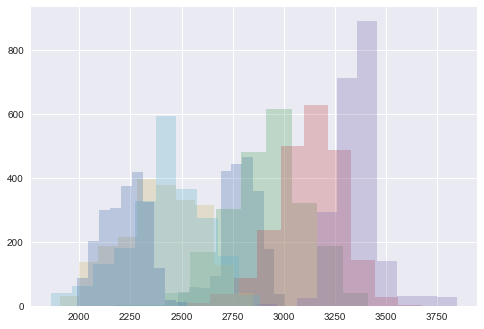

In [10]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

for label in labels.unique():
    plt.hist(data.Elevation[labels==label], **kwargs)

Elevation seems to be one of the more binnable for the cover type.  We made a note to focus on this variable.

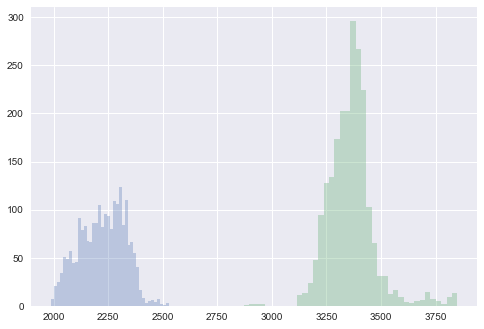

In [11]:
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)

plt.hist(data.Elevation[labels==4], **kwargs)
plt.hist(data.Elevation[labels==7], **kwargs);

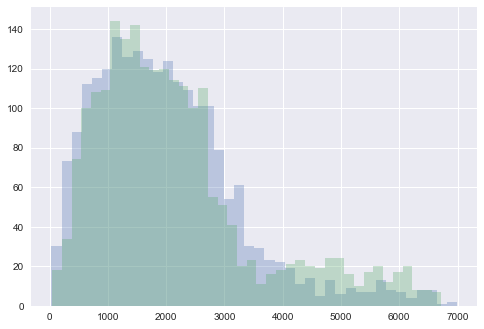

In [12]:
plt.hist(data.Horizontal_Distance_To_Fire_Points[labels==1], **kwargs)
plt.hist(data.Horizontal_Distance_To_Fire_Points[labels==2], **kwargs);

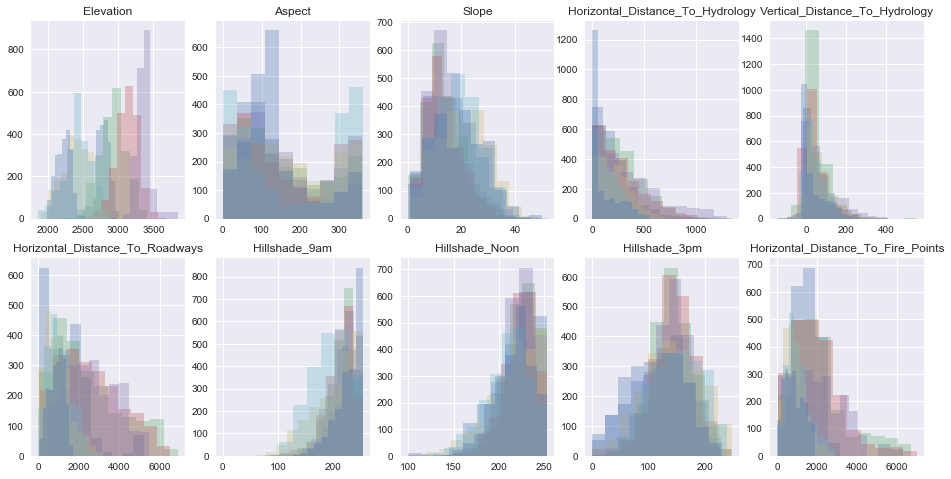

In [13]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, axi in enumerate(ax.flat):
    for label in labels.unique():
        axi.hist(data.ix[labels==label, i], **kwargs)
    axi.set_title(data.columns[i])

From this, we can see that elevation has the most amount of variability between the different cover types.  Many of the other variables seem to overlap quite a lot for the different cover types, which indicates that they will not be very helpful in differentiating the different cover type.  The other notable features are the Horizontal and Veritcal distances to the disturbances, which have a bit more variation.  

In [14]:
vars = [x for x in data.columns.tolist() if "Soil_Type" not in x]
vars = [x for x in vars if "Wilderness" not in x]
df1 = data.reindex(columns=vars)

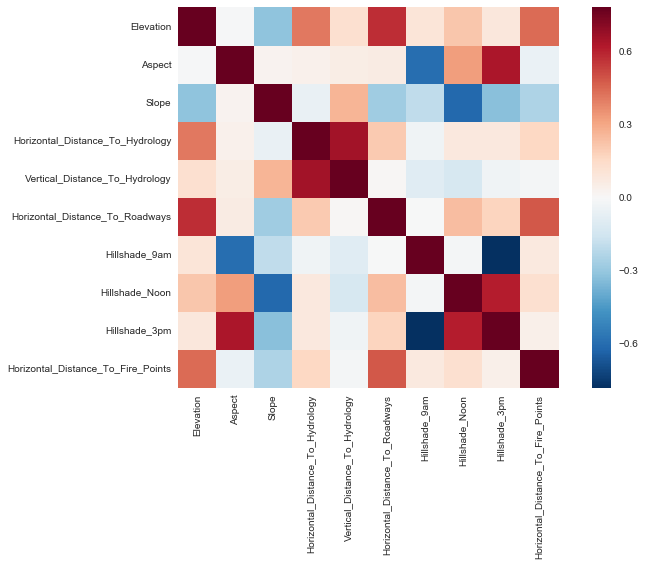

In [15]:
corrmat = df1.corr()
f, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(corrmat, vmax=.5, square=True);

From this, we can see several things. First, the vertical and horizonal distances are pretty strongly correlated.  Second, the HIllshade_3pm is positively correlated with Hillsahde_noon, and negatively correlated with Hillshade_9am.  We can also see that there is a positive correlation with aspect as well.

/Users/mac28/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


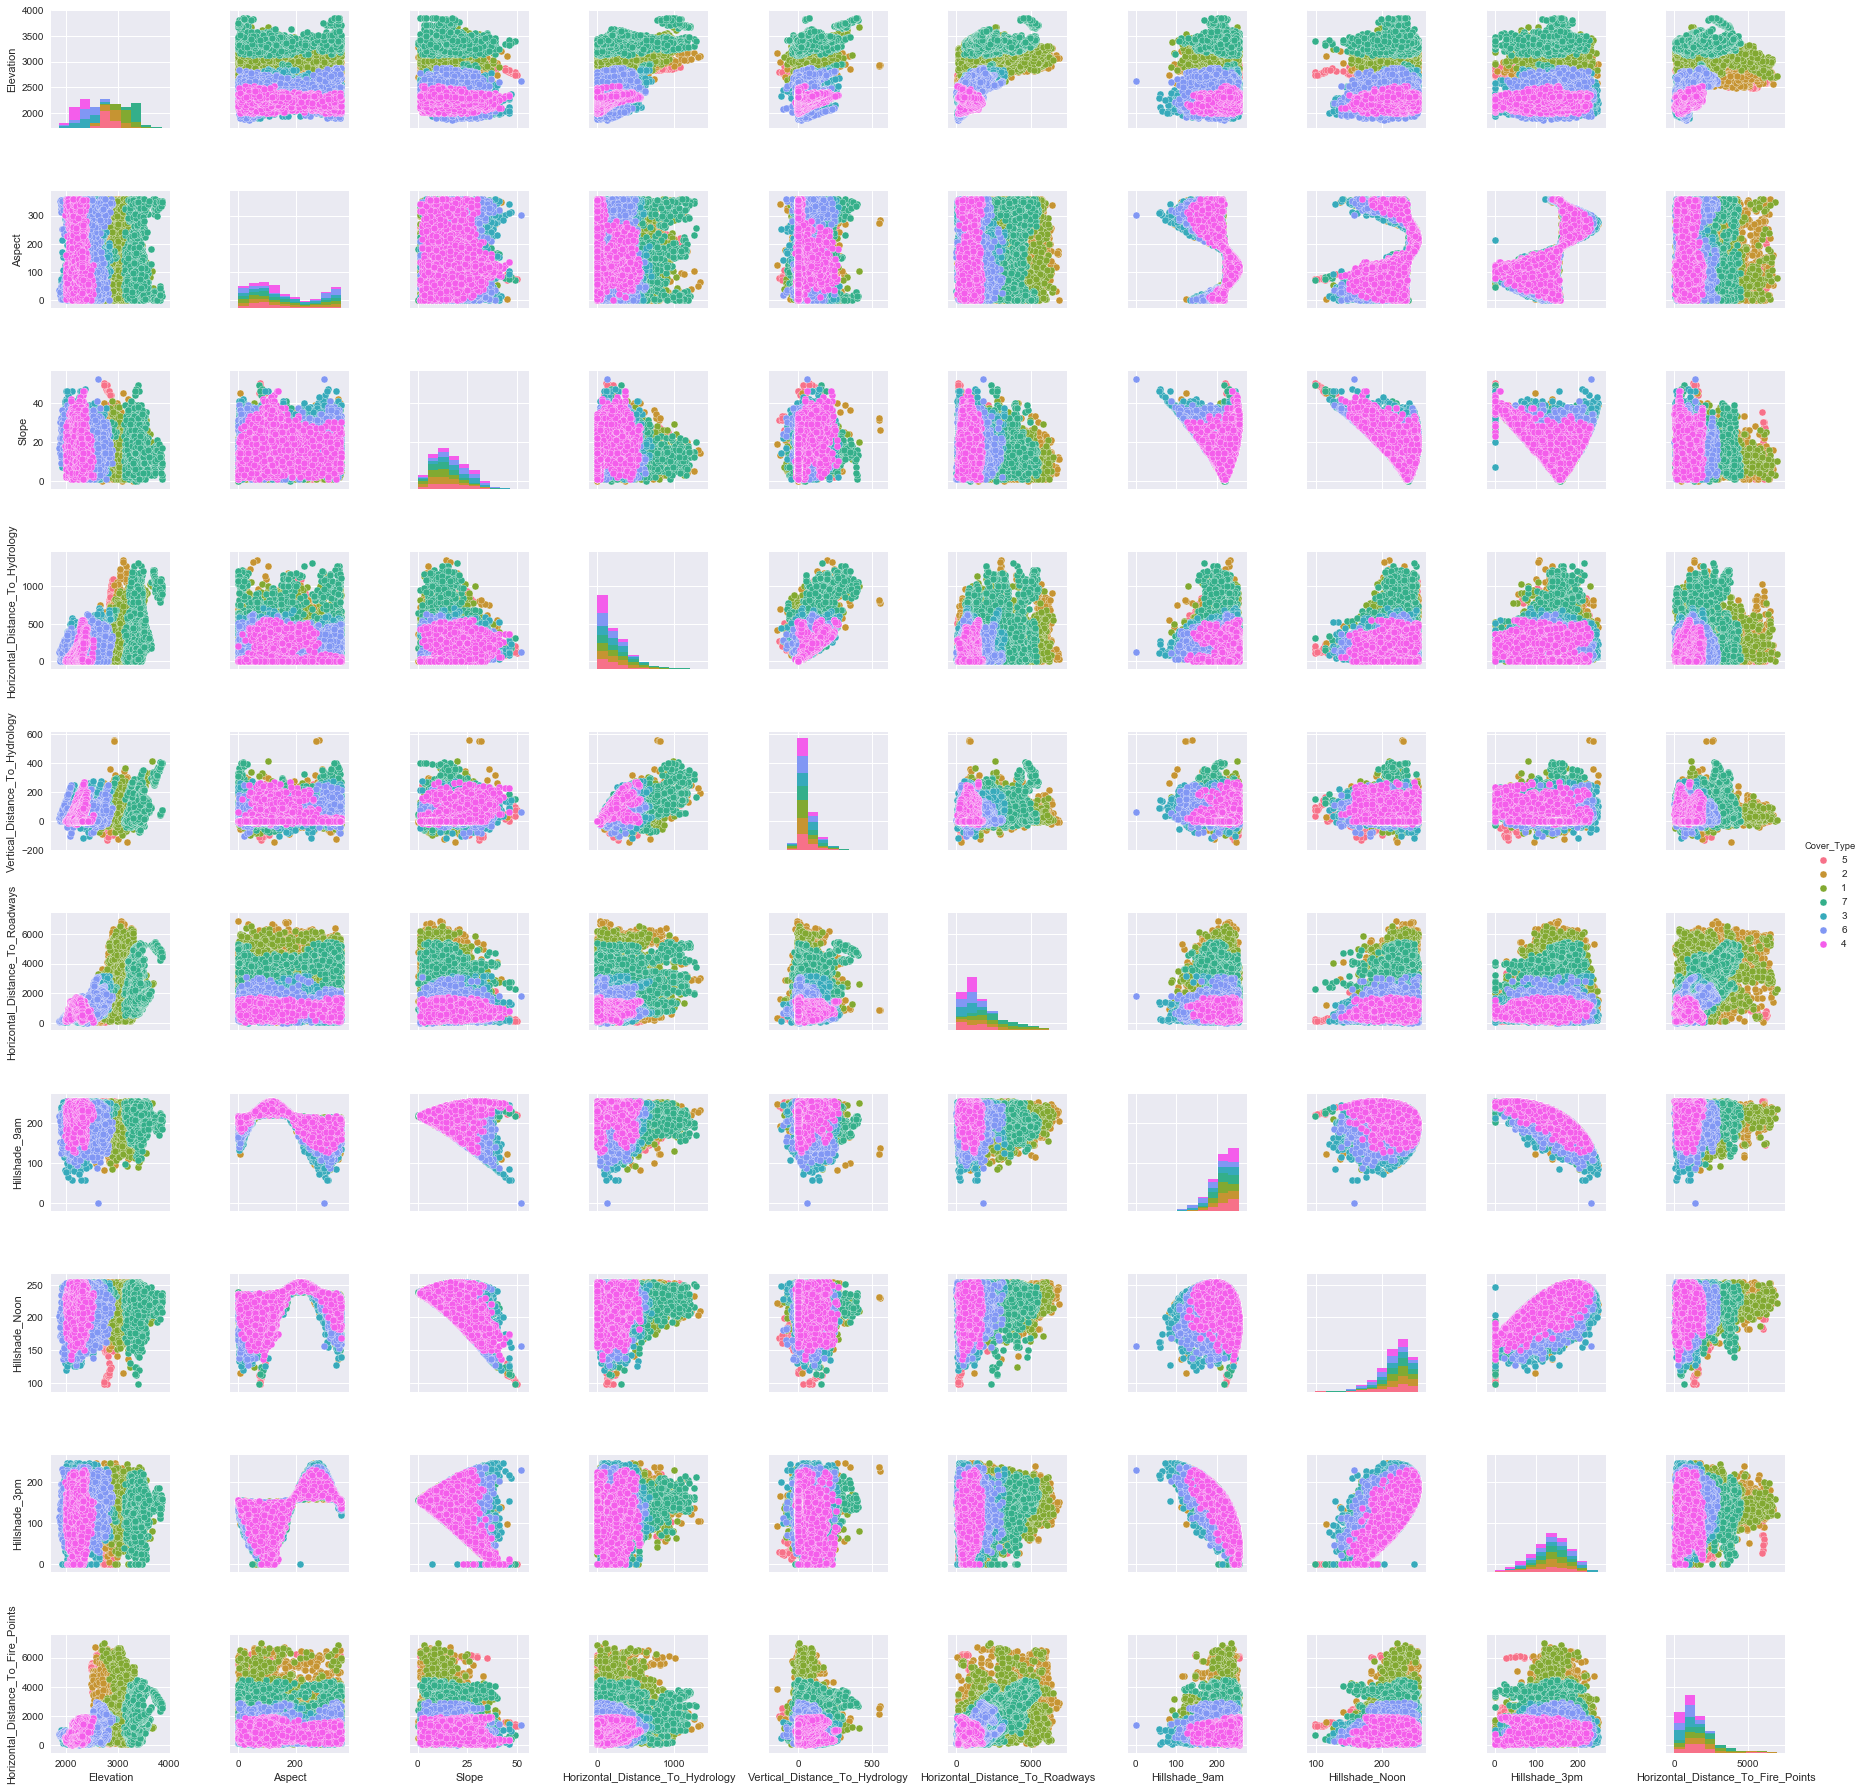

In [16]:
g = sns.pairplot(df, vars=vars, hue="Cover_Type")

In [17]:
# Count different soil types
data.loc[:, 'Soil_Type1':'Soil_Type40'].sum(axis=1).describe()

count    15120
mean         1
std          0
min          1
25%          1
50%          1
75%          1
max          1
dtype: float64

In [18]:
col_names = df.columns.tolist()
A = np.array(col_names)
soil_types = [item for item in A if "Soil" in item]
for soil_type in soil_types:
    print (soil_type, df[soil_type].sum())

('Soil_Type1', 355)
('Soil_Type2', 623)
('Soil_Type3', 962)
('Soil_Type4', 843)
('Soil_Type5', 165)
('Soil_Type6', 650)
('Soil_Type7', 0)
('Soil_Type8', 1)
('Soil_Type9', 10)
('Soil_Type10', 2142)
('Soil_Type11', 406)
('Soil_Type12', 227)
('Soil_Type13', 476)
('Soil_Type14', 169)
('Soil_Type15', 0)
('Soil_Type16', 114)
('Soil_Type17', 612)
('Soil_Type18', 60)
('Soil_Type19', 46)
('Soil_Type20', 139)
('Soil_Type21', 16)
('Soil_Type22', 345)
('Soil_Type23', 757)
('Soil_Type24', 257)
('Soil_Type25', 1)
('Soil_Type26', 54)
('Soil_Type27', 15)
('Soil_Type28', 9)
('Soil_Type29', 1291)
('Soil_Type30', 725)
('Soil_Type31', 332)
('Soil_Type32', 690)
('Soil_Type33', 616)
('Soil_Type34', 22)
('Soil_Type35', 102)
('Soil_Type36', 10)
('Soil_Type37', 34)
('Soil_Type38', 728)
('Soil_Type39', 657)
('Soil_Type40', 459)


Soil types don't seem to be very consisten, and some soil types have 0 data points, which may need to be dropped.  Overall, we may find that the soil type won't be too helpful.

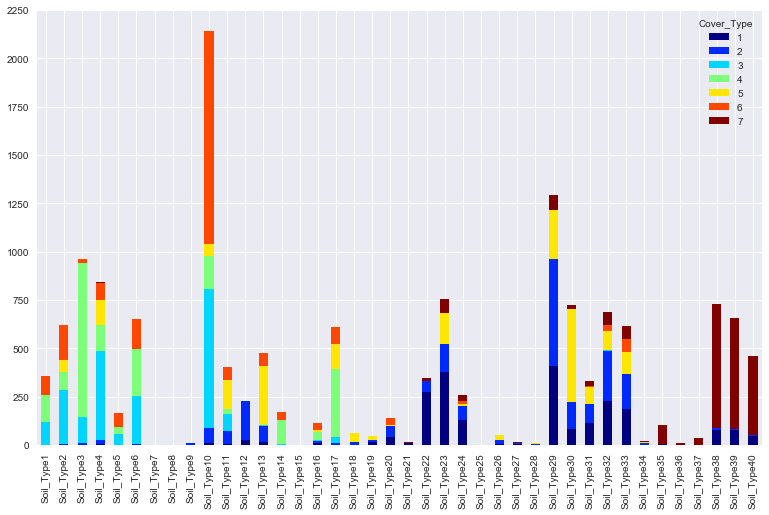

In [19]:
types_sum = df[soil_types].groupby(df['Cover_Type']).sum()
types_sum.T.plot(kind='bar', stacked=True, figsize=(13,8), cmap='jet')

We can see some subtle differences when plotting the cover type that different soils have.  For example, cover type 7 seems to be heavily on the soil types 38,39,40.  In addition, cover type 6 seems to trend towards the lower soil types.  Other points seem to be a bit more scattered.

In [20]:
# Count at different wilderness areass
data.loc[:, 'Wilderness_Area1':'Wilderness_Area4'].sum(axis=1).describe()

count    15120
mean         1
std          0
min          1
25%          1
50%          1
75%          1
max          1
dtype: float64

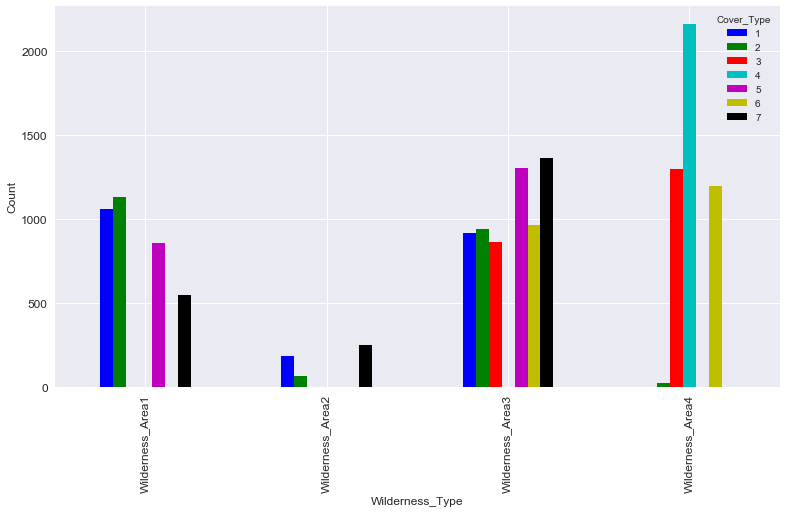

In [21]:
col_names_wilderness = [x for x in df.columns.tolist() if "Wilderness" in x]
types_sum = df[col_names_wilderness].groupby(df['Cover_Type']).sum()
ax = types_sum.T.plot(kind='bar', figsize=(13, 7), legend=True, fontsize=12)
ax.set_xlabel("Wilderness_Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

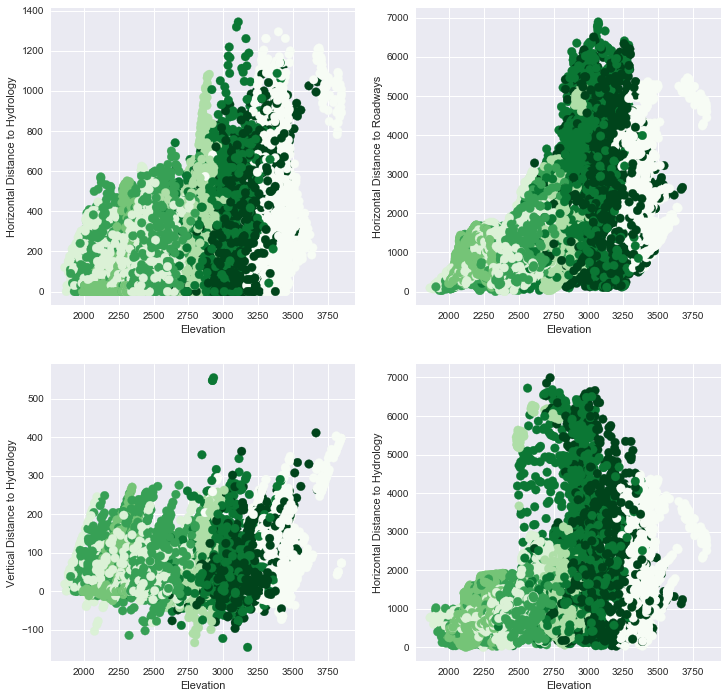

In [52]:
#Elevation vs Horizontal Distance to Hydrology 
plt.figure(figsize=(12,12)) 
plt.subplot(221)
plt.scatter(df.Elevation, df.Horizontal_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Hydrology")
plt.subplot(222)
plt.scatter(df.Elevation, df.Horizontal_Distance_To_Roadways, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Roadways") 
plt.subplot(223)
plt.scatter(df.Elevation, df.Vertical_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Vertical Distance to Hydrology")
plt.subplot(224)
plt.scatter(df.Elevation, df.Horizontal_Distance_To_Fire_Points, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Hydrology") 

plt.show()

Looking at this, we can see with a small adjustment to the elevation values in relation to the horizontal distance to hydrology, we can get the labels differentiated better.  We try to do this in the next figure.

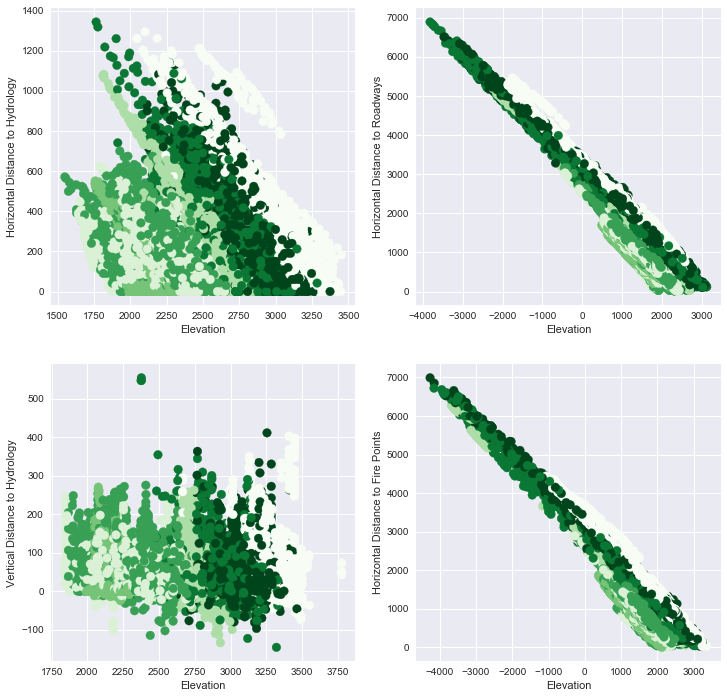

In [97]:
#Elevation vs Horizontal Distance to Hydrology 
plt.figure(figsize=(12,12)) 
plt.subplot(221)
plt.scatter(df.Elevation - df.Horizontal_Distance_To_Hydrology, df.Horizontal_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Hydrology")
plt.subplot(222)
plt.scatter(df.Elevation - df.Horizontal_Distance_To_Roadways, df.Horizontal_Distance_To_Roadways, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Roadways") 
plt.subplot(223)
plt.scatter(df.Elevation - df.Vertical_Distance_To_Hydrology, df.Vertical_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Vertical Distance to Hydrology")
plt.subplot(224)
plt.scatter(df.Elevation - df.Horizontal_Distance_To_Fire_Points, df.Horizontal_Distance_To_Fire_Points, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Fire Points") 

plt.show()

We can see that the cover types cluster a bit better.  We can see if adjusting this will help with the model.

# Dimensionality Reduction

We'd  like to reduce our feature space to make our modelling simpler, while hopefully preserving the variablility/information in our data.

Below we explore how much variance is explained as we increase the number of PCA components. We found that there was not a logical cut off that allowed us to both reduce the number of features, and preserve variance within the data.

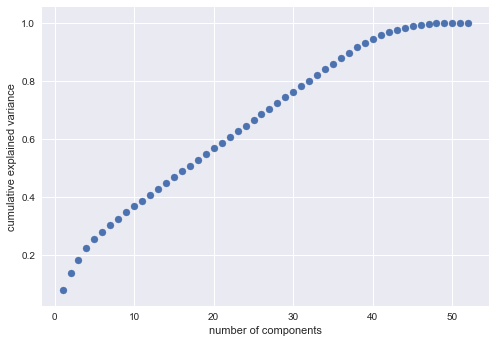

In [22]:
pca = PCA(n_components=52)
pca.fit(X_train_std)
plt.scatter(range(1,53),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

We'd also like to see if on an extremely simplified case with only 2 PCA components if we could pick find visibly separable data.

In [23]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_train_std)

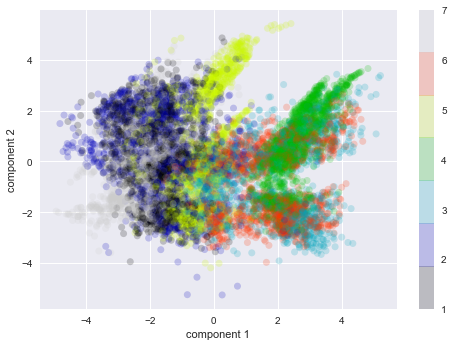

In [24]:
plt.scatter(X_2D[:, 0], X_2D[:, 1],
            c=y_train, edgecolor='none', alpha=0.2,
            cmap=plt.cm.get_cmap('nipy_spectral', 7))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

After additional attempts, we didn't find strong evidence that PCA was going to help us much. See the the appendix at the end of this notebook for additional trials with PCA

# Feature Engineering

After many trials the only feature that we saw significant accuracy benefits from was adding a new variable, which took the mean of all of the horizontal distance metrics to our model. Our intuition around this metric could be simplified down to average distance to "disturbance", if we consider fires, roads, and water sources of potential "disturbance."

In [30]:
#Mean distance to Disturbances 
means_train = pd.DataFrame()
means_test = pd.DataFrame()

means_train['Mean_Disturbances'] = (X_train.Horizontal_Distance_To_Fire_Points + X_train.Horizontal_Distance_To_Hydrology + X_train.Horizontal_Distance_To_Roadways) / 3 
means_test['Mean_Disturbances'] = (X_test.Horizontal_Distance_To_Fire_Points + X_test.Horizontal_Distance_To_Hydrology + X_test.Horizontal_Distance_To_Roadways) / 3 

means_train['Mean_Fire_Hyd']=(X_train.Horizontal_Distance_To_Fire_Points + X_train.Horizontal_Distance_To_Hydrology) / 2
means_test['Mean_Fire_Hyd']=(X_test.Horizontal_Distance_To_Fire_Points + X_test.Horizontal_Distance_To_Hydrology) / 2 

means_train.index = X_train.index
means_test.index = X_test.index

X_train_means = pd.concat([X_train,means_train], axis =1, join_axes=[X_train.index])
X_test_means = pd.concat([X_test,means_test], axis=1, join_axes=[X_test.index])

# Test on a model

without_mean = []
with_mean = []
for i in range(10):
    log = RandomForestClassifier()
    log.fit(X_train, y_train)
    without_mean.append(log.score(X_test, y_test))

    log.fit(X_train_means, y_train)
    with_mean.append(log.score(X_test_means, y_test))
print "Accuracy without extra mean feature is {}".format(np.mean(without_mean))
print "Accuracy with extra mean feature is {}".format(np.mean(with_mean))

Accuracy without extra mean feature is 0.824709418838
Accuracy with extra mean feature is 0.838436873747


We know we want to keep this feature, so we'll permanently incorporate it into our data.

In [25]:
# Adding this feature permanently to our data 
X_train_std = pd.DataFrame(X_train_std)
X_test_std = pd.DataFrame(X_test_std)

In [26]:
X_train_std.columns, X_train_std.index = X_train.columns, X_train.index
X_test_std.columns, X_test_std.index = X_test.columns, X_test.index

In [27]:
X_train_std = pd.concat([X_train_std,means_train], axis =1, join_axes=[X_train_std.index])
X_test_std = pd.concat([X_test_std,means_test], axis =1, join_axes=[X_test_std.index])

In [31]:
X_train_std.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Mean_Disturbances,Mean_Fire_Hyd
3388,-1.453272,-0.532923,0.301270,-1.090111,-0.839309,-0.707513,1.129619,-0.395190,-1.125552,-0.638824,...,-0.206942,-0.035846,-0.07719,-0.024344,-0.04974,-0.224243,-0.215359,-0.177082,531.666667,407.5
10782,-0.355024,0.723118,1.608889,-0.658674,-0.363726,-0.210032,-1.936839,1.320537,1.866208,-0.181880,...,-0.206942,-0.035846,-0.07719,-0.024344,-0.04974,-0.224243,-0.215359,-0.177082,951.000000,704.0
13624,0.627871,-1.382332,-1.125224,-0.946299,-0.839309,0.190197,-0.044769,0.308698,0.381247,1.434231,...,-0.206942,-0.035846,-0.07719,-0.024344,-0.04974,-0.224243,-0.215359,-0.177082,1702.333333,1563.5
7855,1.565107,-1.174498,-0.411977,1.742993,1.882996,1.051999,0.053097,-0.307204,-0.077344,0.502174,...,-0.206942,-0.035846,-0.07719,-0.024344,-0.04974,-0.224243,4.643409,-0.177082,1931.333333,1331.0
11884,1.156569,1.590600,-1.244098,-0.572387,-0.757312,2.147206,-0.240500,0.572656,0.643299,-0.715133,...,-0.206942,-0.035846,-0.07719,-0.024344,-0.04974,-0.224243,4.643409,-0.177082,1811.666667,419.5


In [98]:
#Adjusting distance to hydrology and roadways 
adj_train = pd.DataFrame()
adj_test = pd.DataFrame()

#Elevation adjusted by Horizontal distance to Hyrdrology 
adj_train['Elev_to_HD_Hyd']=X_train.Elevation - X_train.Horizontal_Distance_To_Hydrology 
adj_test['Elev_to_HD_Hyd']=X_test.Elevation - X_test.Horizontal_Distance_To_Hydrology 

#Elevation adjusted by Horizontal distance to Roadways 
adj_train['Elev_to_HD_Road']=X_train.Elevation - X_train.Horizontal_Distance_To_Roadways 
adj_test['Elev_to_HD_Road']=X_test.Elevation - X_test.Horizontal_Distance_To_Roadways 

#Elevation adjusted by Vertical distance to Roadways 
adj_train['Elev_to_VD_Hyd']=X_train.Elevation - X_train.Vertical_Distance_To_Hydrology 
adj_test['Elev_to_VD_Hyd']=X_test.Elevation - X_test.Vertical_Distance_To_Hydrology 

#Elevation adjusted by Horizontal distance to Fire Points 
adj_train['Elev_to_Fire_Points']=X_train.Elevation - X_train.Horizontal_Distance_To_Fire_Points 
adj_test['Elev_to_Fire_Points']=X_test.Elevation - X_test.Horizontal_Distance_To_Fire_Points 

adj_train.index = X_train.index
adj_test.index = X_test.index

X_train_adj = pd.concat([X_train,adj_train], axis =1, join_axes=[X_train.index])
X_test_adj = pd.concat([X_test,adj_test], axis=1, join_axes=[X_test.index])

# Test on a model

without_adj = []
with_adj = []
for i in range(10):
    log = RandomForestClassifier()
    log.fit(X_train, y_train)
    without_adj.append(log.score(X_test, y_test))

    log.fit(X_train_adj, y_train)
    with_adj.append(log.score(X_test_adj, y_test))
print "Accuracy without extra adj feature is {}".format(np.mean(without_adj))
print "Accuracy with extra adj feature is {}".format(np.mean(with_adj))


Accuracy without extra adj feature is 0.823246492986
Accuracy with extra adj feature is 0.85004008016


# Appendix
a. There being so many soil types, we thought that it might be advantageous to utilze PCA to reduce the variables needed.

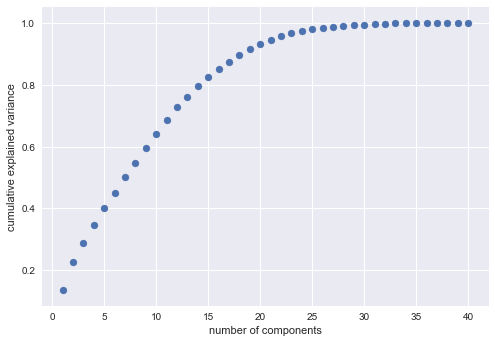

In [31]:
# Separate soil data from X_train

X_train_less_soil = X_train.drop([i for i in X_train.columns if "Soil_Type" in i],axis=1)
X_test_less_soil = X_test.drop([i for i in X_test.columns if "Soil_Type" in i],axis=1)

soil_train = X_train[[i for i in X_train.columns if "Soil_Type" in i]]
soil_test = X_test[[i for i in X_test.columns if "Soil_Type" in i]]

pca = PCA(n_components=40)
pca.fit(soil_train)
plt.scatter(range(1,41),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

**We see that with only 15 components that we preserve about 80% of the variation.**

In [32]:
# Fit PCA and transform train and test data
p = PCA(n_components=15)
pca_soil_train = p.fit_transform(soil_train)
pca_soil_test = p.transform(soil_test)

# Convert back to Dataframes
pca_soil_train = pd.DataFrame(pca_soil_train)
pca_soil_test = pd.DataFrame(pca_soil_test)

# Make sure they're still on same index
pca_soil_train.index = soil_train.index
pca_soil_test.index = soil_test.index

# Put data back together
soil_pca_X_train = pd.concat([X_train_less_soil,pca_soil_train],axis=1,join_axes=[X_train_less_soil.index])
soil_pca_X_test = pd.concat([X_test_less_soil,pca_soil_test],axis=1,join_axes=[X_test_less_soil.index])

RF = RandomForestClassifier()

RF.fit(X_train, y_train)
print("The accuracy score before PCA reduction was: {}".format(RF.score(X_test, y_test)))

RF.fit(soil_pca_X_train, y_train)
print("The accuracy score before PCA reduction was: {}".format(RF.score(soil_pca_X_test, y_test)))

The accuracy score before PCA reduction was: 0.812625250501
The accuracy score before PCA reduction was: 0.826853707415


A feature that we thought would be helpful to engineer would be the  slope of the elevation based on the elevation and the horizontal distance to hydrology.  However, by engineering this feature, we didn't see much improvement and therefore this feature was discarded.

In [39]:
#Adjusting distance to hydrology and roadways 
slope_train = pd.DataFrame()
slope_test = pd.DataFrame()

#Elevation adjusted by Horizontal distance to Hyrdrology 
slope_train['slope_hyd'] = np.sqrt(X_train.Vertical_Distance_To_Hydrology**2 + X_train.Horizontal_Distance_To_Hydrology**2) 
slope_train.slope_hyd=slope_train.slope_hyd.map(lambda x: 0 if np.isnan(x) else x) 
slope_train['slope_hyd_pct'] = X_train.Vertical_Distance_To_Hydrology / X_train.Horizontal_Distance_To_Hydrology
slope_train.slope_hyd_pct=slope_train.slope_hyd_pct.map(lambda x: 0 if np.isnan(x) else x)

slope_test['slope_hyd'] = np.sqrt(X_test.Vertical_Distance_To_Hydrology**2 + X_test.Horizontal_Distance_To_Hydrology**2) 
slope_test.slope_hyd=slope_test.slope_hyd.map(lambda x: 0 if np.isnan(x) else x) 
slope_test['slope_hyd_pct'] = X_test.Vertical_Distance_To_Hydrology / X_test.Horizontal_Distance_To_Hydrology
slope_test.slope_hyd_pct=slope_test.slope_hyd_pct.map(lambda x: 0 if np.isnan(x) else x)

slope_train.index = X_train.index
slope_test.index = X_test.index

X_train_slope = pd.concat([X_train,slope_train], axis =1, join_axes=[X_train.index])
X_test_slope = pd.concat([X_test,slope_test], axis=1, join_axes=[X_test.index])

# Test on a model

without_slope = []
with_slope = []
for i in range(10):
    log = RandomForestClassifier()
    log.fit(X_train, y_train)
    without_slope.append(log.score(X_test, y_test))

    log.fit(X_train_slope, y_train)
    with_slope.append(log.score(X_test_slope, y_test))
print "Accuracy without extra slope feature is {}".format(np.mean(without_slope))
print "Accuracy with extra slope feature is {}".format(np.mean(with_slope))

Accuracy without extra slope feature is 0.823987975952
Accuracy with extra slope feature is 0.820601202405
